In [14]:
import warnings
import os
warnings.filterwarnings("ignore") 

# Suppress TensorFlow logging messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import json
import os
import pandas as pd
import pysam
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from basenji import seqnn, stream, dataset, dna_io

from akita_utils.numpy_utils import ut_dense
from akita_utils.dna_utils import dna_1hot

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU
print(tf.config.list_physical_devices('GPU'))

[]


### Cropping functions

In [3]:
def crop_center(matrix, new_height=448, new_width=448):
    """
    Crop the central part of a matrix to a specified size.
    
    Parameters:
    - matrix: Input 2D numpy array of shape (height, width).
    - new_height: Height of the cropped matrix.
    - new_width: Width of the cropped matrix.
    
    Returns:
    - Cropped 2D numpy array of shape (new_height, new_width).
    """
    # Calculate the starting points for cropping
    start_x = (matrix.shape[1] - new_width) // 2
    start_y = (matrix.shape[0] - new_height) // 2
    
    # Perform the cropping
    cropped_matrix = matrix[start_y:start_y+new_height, start_x:start_x+new_width]
    
    return cropped_matrix


def matrix_to_upper_triangular_vector_excluding_diagonals(matrix, diagonals_to_exclude=2):
    """
    Convert a square matrix to a vector containing only the upper triangular part,
    excluding a specified number of diagonals from the start.
    
    Parameters:
    - matrix: 2D numpy array of shape (N, N)
    - diagonals_to_exclude: Number of diagonals to exclude from the start (default is 2)
    
    Returns:
    - Vector containing the upper triangular part of the matrix, excluding the specified diagonals.
    """
    # Use np.triu_indices to get the indices of the upper triangular part, excluding specified diagonals
    upper_tri_indices = np.triu_indices(matrix.shape[0], diagonals_to_exclude)
    
    # Extract the upper triangular part of the matrix using the indices
    upper_tri_vector = matrix[upper_tri_indices]
    
    return upper_tri_vector


def crop_and_vectorize(vector_prediction):
    maps = ut_dense(vector_prediction[0,:,:])
    cropped_maps = np.array([crop_center(maps[:,:,target_index]) for target_index in range(maps.shape[2])])
    cropped_maps = np.transpose(cropped_maps, (1, 2, 0))
    vectorized = np.array([matrix_to_upper_triangular_vector_excluding_diagonals(cropped_maps[:,:,target_index]) for target_index in range(maps.shape[2])])
    return np.transpose(vectorized, (1, 0))

In [4]:
# read data parameters
human_dir = "/project/fudenber_735/tensorflow_models/akita/v2/data/hg38/"
data_stats_file = '%s/statistics.json' % human_dir
with open(data_stats_file) as data_stats_open:
    data_stats = json.load(data_stats_open)
seq_length = data_stats['seq_length']
target_length = data_stats['target_length']
hic_diags =  data_stats['diagonal_offset']
target_crop = data_stats['crop_bp'] // data_stats['pool_width']
target_length1 = data_stats['seq_length'] // data_stats['pool_width']

### Reading test dataframe and loading targets

In [5]:
v1_data_split_path = "/project/fudenber_735/tensorflow_models/akita/v1/data/sequences.bed"
all_test_V1_seqs = pd.read_csv(v1_data_split_path, sep='\t', names=['chr','start','stop','type'])
all_test_V1_seqs = all_test_V1_seqs.iloc[all_test_V1_seqs['type'].values=='test']

overlap_test = pd.read_csv("./data/v1_v2_sequences.tsv", sep='\t')
num_models = overlap_test.type_v2.nunique()
overlap_test["model"] = overlap_test.apply(lambda x: int(str(x.type_v2)[-1]), axis=1)

# reading inputs and targets
data_dir_v1 = "/project/fudenber_735/tensorflow_models/akita/v1/data/"
test_data_v1 = dataset.SeqDataset(data_dir_v1, 'test', batch_size=8)
test_inputs, test_targets = test_data_v1.numpy(return_inputs=True, return_outputs=True)

# calculate the difference in windows' sizes
v1_seq_length = len(test_inputs[0])
v2_seq_length = 1310720
to_expand = (v2_seq_length - v1_seq_length) // 2

### Checking which models we need

In [6]:
fig_examples = [   'chr1:73918464-74967040',
                    'chr9:132390912-133439488']
fig_inds = []
for seq in fig_examples:
    chrm,start,stop = seq.split(':')[0], seq.split(':')[1].split('-')[0], seq.split(':')[1].split('-')[1]
    test_ind = np.where( (all_test_V1_seqs['chr'].values== chrm) *
                         (all_test_V1_seqs['start'].values== int(start))*
                         (all_test_V1_seqs['stop'].values==  int(stop ))  )[0][0]
    fig_inds.append(test_ind)

In [7]:
overlap_test[overlap_test["start"] == 73918464]
# overlap_test[overlap_test["start"] == 132390912]

,chr,start,stop,type_v2,model
3,chr1,73918464,74967040,fold0,0


### General models parameters

In [8]:
# model's parameters
batch_size=8 
head_index = 0 # human!
shifts = "0"
rc = False
shifts = [int(shift) for shift in shifts.split(",")]

# directory with models
models_dir = "/project/fudenber_735/tensorflow_models/akita/v2/models"

### Loading the right model

In [9]:
# open genome FASTA
genome_fasta = "/project/fudenber_735/genomes/hg38/hg38.fa"
genome_open = pysam.Fastafile(genome_fasta)

# picking the model
model_index = 0
# model_index = 5

In [10]:
params_file = models_dir + f"/f{model_index}c0" + "/train" + "/params.json"
model_file = models_dir + f"/f{model_index}c0" + "/train" + f"/model{head_index}_best.h5"

# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_train = params["train"]
params_model = params["model"]

if batch_size is None:
    batch_size = params_train["batch_size"]
else:
    batch_size = batch_size

# load model
seqnn_model = seqnn.SeqNN(params_model)
seqnn_model.restore(model_file, head_i=head_index)
seqnn_model.build_ensemble(rc, shifts)
seq_length = int(params_model["seq_length"])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1310720, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1310720, 4),         0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 1310720, 4)           0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

### Plotting example maps (no and big improvement)

In [11]:
# a point very close to diagonal (no improvement) -> chr1:73918464-74967040 (model 0)
chr = "chr1"
start = 73918464
end = 74967040

# a point with much better performance -> chr9:132390912-133439488 (model 5)
# chr = "chr9"
# start = 132390912
# end = 133439488

1/1 [==============================] - 1s 937ms/step
prediction: 


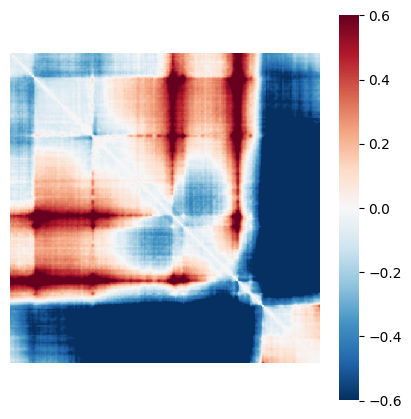

In [18]:
test_index = np.where((all_test_V1_seqs['start'].values == int(start)))[0][0]

v2_seq_start, v2_seq_end = start - to_expand, end + to_expand
# fetching
seq_1hot = dna_1hot(
        genome_open.fetch(
            chr, v2_seq_start, v2_seq_end
        ).upper()
    )
expanded_seq_1hot = np.expand_dims(seq_1hot, 0)

test_target = test_targets[test_index:test_index+1,:,:]
test_target = np.squeeze(test_target, axis=0)
test_pred = seqnn_model.model.predict(expanded_seq_1hot)
# cropped_pred = crop_and_vectorize(test_pred)

# target of interest
target_index = 0

test_pred_maps = ut_dense(test_pred[0,:,:])
# ave_test_pred_maps = np.mean(test_pred_maps, axis=2)

# saving
#np.savez(f'./matrices/{chr}_{start}-{end}_map_v2_tg0.npz', prediction=test_pred_maps[:,:,target_index])

print("prediction: ")

fig = plt.figure(figsize=(5, 5))

sns.heatmap(
    test_pred_maps[:,:,target_index],
    vmin=-0.6,
    vmax=0.6,
    cbar=True,
    cmap="RdBu_r",
    square=True,
    xticklabels=False,
    yticklabels=False)
plt.show()